<a href="https://colab.research.google.com/github/ubermenchh/fun/blob/main/nlp_with_transformers/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets

In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print('Total no. of datasets available on hub: ', len(all_datasets))
print('First 10: ', all_datasets[:10])

<ipython-input-2-b9b48aaa85be>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


Total no. of datasets available on hub:  81247
First 10:  ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset
emotions = load_dataset('emotion')

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [10]:
import pandas as pd

emotions.set_format(type='pandas') # change the output format of the data to pd.DataFrame
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_int2str(row): return emotions['train'].features['label'].int2str(row)

In [12]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


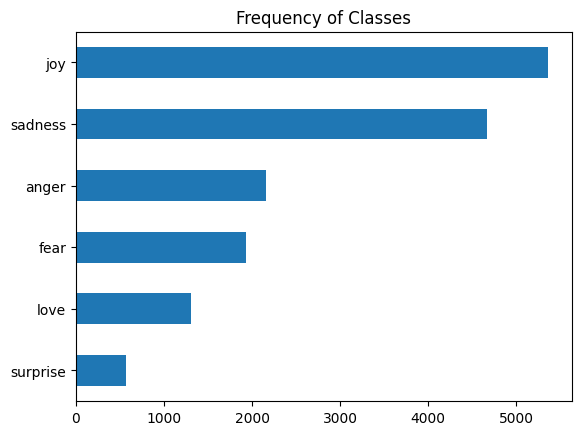

In [13]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

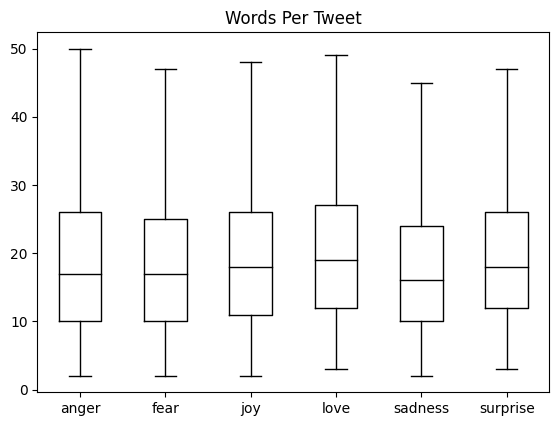

In [14]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [15]:
emotions.reset_format() # remove the pd.DataFrame format

In [16]:
from transformers import AutoTokenizer

In [17]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [19]:
text = 'AGI has been achieved internally'
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 12943, 2072, 2038, 2042, 4719, 16058, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'ag', '##i', 'has', 'been', 'achieved', 'internally', '[SEP]']


In [21]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] agi has been achieved internally [SEP]


In [22]:
tokenizer.vocab_size

30522

In [23]:
tokenizer.model_max_length # maximum context length

512

In [24]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [25]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

- **padding** -> pad the examples with zeros to the size of the longest one in a batch
- **truncation** -> truncate the examples to the model's maximum context size

In [26]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


**attention_mask** -> allows the model to ignore the padded parts of the input

In [27]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [28]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [29]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [30]:
inputs = tokenizer(text, return_tensors='pt')
print("Input tensor shape: ", inputs['input_ids'].size())

Input tensor shape:  torch.Size([1, 8])


In [31]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2767, -0.1045,  0.0754,  ..., -0.2375,  0.2015,  0.4379],
         [-0.6056, -0.0927,  0.0774,  ..., -0.5050,  0.7251,  0.8692],
         [-0.6012, -0.2295,  0.2960,  ..., -0.6185, -0.0124,  0.0613],
         ...,
         [-0.3082,  0.0036,  0.1850,  ..., -0.4598, -0.0475,  0.3123],
         [-0.1453, -0.0579, -0.0749,  ..., -0.2227,  0.0963,  0.2101],
         [ 0.7197,  0.0847, -0.3369,  ...,  0.1220, -0.6033, -0.2465]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [32]:
outputs.last_hidden_state.size()

torch.Size([1, 8, 768])

In [33]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [34]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [35]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [36]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [37]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [38]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

In [39]:
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [40]:
!pip install -q umap-learn

In [41]:
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.180673,7.291999,0
1,-3.243412,6.182668,0
2,5.129171,3.903087,3
3,-2.568144,4.259658,2
4,-3.602785,4.234295,3


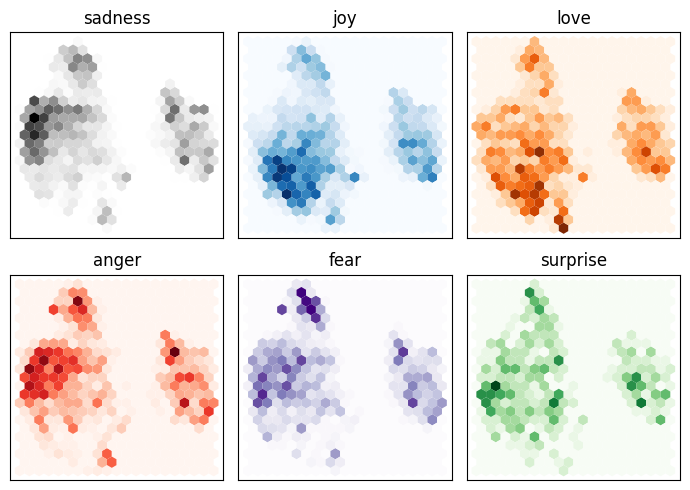

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [43]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [44]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

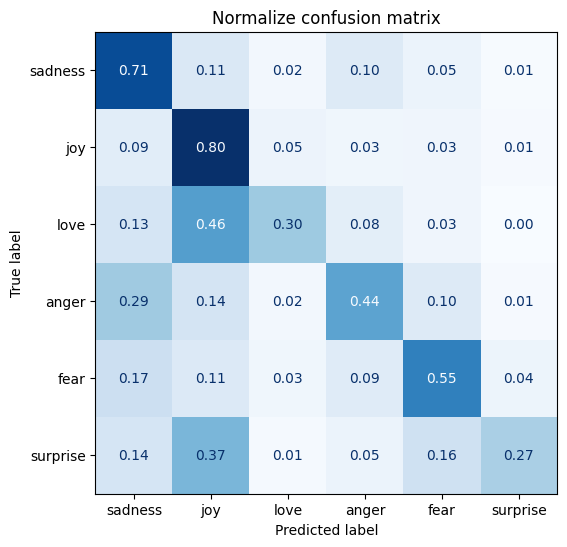

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalize confusion matrix')
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [46]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [48]:
from huggingface_hub import notebook_login
notebook_login()

In [61]:
!pip install -qU accelerate transformers[torch]

In [63]:
!pip show accelerate

Name: accelerate
Version: 0.24.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, torch
Required-by: 


In [49]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level='error'
)

In [50]:
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.747600
1000,0.335600
1500,0.273500
2000,0.235100
2500,0.158700
3000,0.163300
3500,0.156300
4000,0.145900
4500,0.103700
5000,0.106000


TrainOutput(global_step=6000, training_loss=0.21739077695210773, metrics={'train_runtime': 549.3934, 'train_samples_per_second': 87.369, 'train_steps_per_second': 10.921, 'total_flos': 1080514292544000.0, 'train_loss': 0.21739077695210773, 'epoch': 3.0})

In [51]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [52]:
preds_output.metrics

{'test_loss': 0.21388040482997894,
 'test_accuracy': 0.9425,
 'test_f1': 0.9424406338130559,
 'test_runtime': 4.6786,
 'test_samples_per_second': 427.479,
 'test_steps_per_second': 53.435}

In [53]:
y_preds = np.argmax(preds_output.predictions, axis=1)

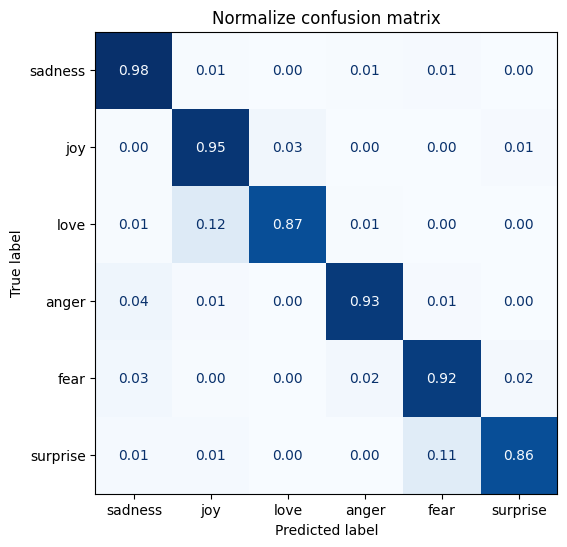

In [54]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [55]:
from torch.nn.functional import cross_entropy

In [56]:
def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}

In [57]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [59]:
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)

In [60]:
df_test.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
1195,i always think about are act the way i want to...,anger,joy,10.492875
1963,i called myself pro life and voted for perry w...,joy,sadness,10.484862
177,im sure much of the advantage is psychological...,sadness,joy,10.285386
982,i never knew i could be so weak i couldnt even...,anger,sadness,10.079115
1124,someone acting stupid in public,anger,sadness,9.932967
1836,i got a very nasty electrical shock when i was...,fear,anger,9.694220
1950,i as representative of everything thats wrong ...,surprise,sadness,8.969398
1367,that day i was alone at home after coming home...,fear,sadness,8.680439
1807,i am afraid of my emotions because certain peo...,sadness,fear,8.652479
415,im kind of embarrassed about feeling that way ...,love,joy,8.232266


In [61]:
df_test.sort_values('loss', ascending=True).head(10)

,text,label,predicted_label,loss
295,i got a sore throat then a runny nose then a f...,sadness,sadness,0.000114
805,i brought it to god and as im dying or feeling...,sadness,sadness,0.000115
1506,ive been feeling quite disillusioned with chri...,sadness,sadness,0.000117
1946,i feel for the kids of troubled homes and i fe...,sadness,sadness,0.000118
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.000119
540,i think im mad at myself for just feeling this...,sadness,sadness,0.000119
1024,i haven t been here for even a year yet i can ...,sadness,sadness,0.000119
1585,i just wanted the dark of night to swallow me ...,sadness,sadness,0.000119
1188,ive been feeling really gloomy about some situ...,sadness,sadness,0.000119
13,i was feeling sentimental,sadness,sadness,0.000119


In [62]:
trainer.push_to_hub(commit_message='Training completed!')

events.out.tfevents.1700949360.f3084f101678.9235.0:   0%|          | 0.00/6.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

'https://huggingface.co/ubermenchh/tmp_trainer/tree/main/'

In [64]:
from transformers import pipeline

model_id = 'ubermenchh/tmp_trainer'
classifier = pipeline('text-classification', model=model_id)
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


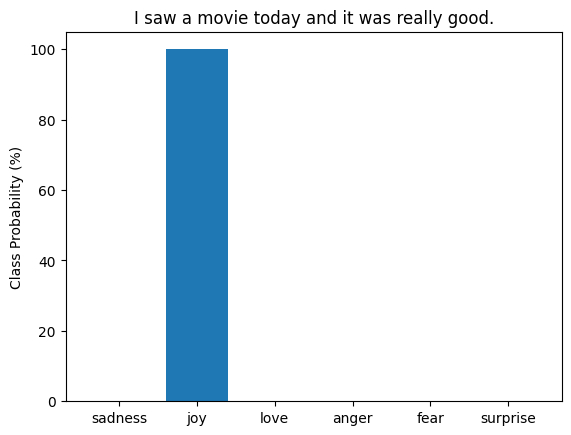

In [65]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df['score'], color='C0')
plt.title(f'{custom_tweet}')
plt.ylabel('Class Probability (%)')
plt.show()